In [261]:
import pandas as pd
import numpy as np 

from palmerpenguins import load_penguins
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, cohen_kappa_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from plotnine import *

In [262]:
df = pd.read_csv('/Users/benji/Documents/Machine Learning/Data/heart_attack.csv')

In [263]:
df.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [264]:
df.isna().sum()

age        0
sex        0
cp         0
trtbps     0
chol       0
restecg    0
thalach    0
output     0
dtype: int64

In [265]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age      273 non-null    int64
 1   sex      273 non-null    int64
 2   cp       273 non-null    int64
 3   trtbps   273 non-null    int64
 4   chol     273 non-null    int64
 5   restecg  273 non-null    int64
 6   thalach  273 non-null    int64
 7   output   273 non-null    int64
dtypes: int64(8)
memory usage: 17.2 KB


In [266]:
df.columns

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'restecg', 'thalach', 'output'], dtype='object')

In [267]:
X = df.drop('output',axis=1)
y = df['output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Part One: Fitting Models 

In [268]:
def modelPipeline(modelName, X=X_train, y=y_train, X_test = X_test, y_test= y_test):
    ct = ColumnTransformer(
    transformers=[
        ('standardize', StandardScaler(),['age', 'sex', 'cp', 'trtbps', 'chol', 'restecg', 'thalach']),
    ], remainder='passthrough'
)
    model = Pipeline(
        steps= [
            ('columnTransforme', ct),
            ('Model',modelName)
        ]
    )
    model.fit(X,y)
    
    yPred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] 

    cm = confusion_matrix(y_test, yPred)
    auc = roc_auc_score(y_test, y_pred_prob)
    ps = precision_score(y_test, yPred)
    rs = recall_score(y_test,yPred)
    kappa = cohen_kappa_score(y_test, yPred)
    specificity_score = recall_score(y_test,yPred, pos_label=0)
    print("AUC Score:", auc)
    print("Confusion Matrix:")
    print(cm)
    return model, y_pred_prob, auc, ps, rs, kappa, cm, specificity_score

In [269]:
def tunning(model,X=X,y=y):
    
    gridSearch = GridSearchCV(model, param_grid = paramGrid , scoring='roc_auc', cv=10)
    gridSearch.fit(X, y)

    return gridSearch.best_params_

## Q1 KNN

In [270]:
knn = KNeighborsClassifier()
# parameter grid
paramGrid = {'n_neighbors': range(1, 21)} 

tunning(knn)


{'n_neighbors': 20}

In [271]:
best_knn = modelPipeline(KNeighborsClassifier(n_neighbors = 20))

AUC Score: 0.833994708994709
Confusion Matrix:
[[19  9]
 [ 4 23]]


Using n_neighbours = 5, model gives us better prediction comapred to using the parameter we got from GridSearchCV, This might be the case of overfitting as the lesser n_neighbours can lead up to over fitting. Let's see the other metrics in Part two.

## Q2 Logistic Regression

ChatGPT was used to create the paramGrid.

In [272]:
lr = LogisticRegression()
paramGrid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear']   # Compatible solver
}
tunning(lr)


{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

In [273]:
best_lr = modelPipeline(LogisticRegression(C = 1, penalty = 'l2', solver = 'liblinear'))

AUC Score: 0.8227513227513228
Confusion Matrix:
[[20  8]
 [ 4 23]]


## Q3 Decision Tree

ChatGPT was used to create the paramGrid.

In [274]:
dt = DecisionTreeClassifier()
paramGrid = {
    'criterion': ['gini', 'entropy'],           # Splitting criteria
    'max_depth': [3, 5, 10, None],              # Tree depth
    'min_samples_split': [2, 5, 10],            # Minimum samples to split
    'min_samples_leaf': [1, 2, 4],              # Minimum samples per leaf
}
tunning(dt)


{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [275]:
best_dt = modelPipeline(DecisionTreeClassifier(criterion='gini', max_depth = 3, min_samples_leaf = 2, min_samples_split = 2))

AUC Score: 0.8247354497354498
Confusion Matrix:
[[24  4]
 [ 7 20]]


## Q4 Interpretation

ChatGPT was used create debug and uderstand the following code.

In [293]:
def extract_feature_importance(model, feature_names):
    """
    Extract and print feature importance or coefficients from a given model.
    Works for tree-based models, logistic regression, and supports permutation importance.

    Parameters:
    - model: Trained pipeline model.
    - feature_names: List of feature names (from X_train.columns).
    
    Returns:
    - A DataFrame containing features and their importance.
    """
    # Check for tree-based feature importance
    if hasattr(model.named_steps['Model'], 'feature_importances_'):
        importance = model.named_steps['Model'].feature_importances_
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    
    # Check for logistic regression coefficients
    elif hasattr(model.named_steps['Model'], 'coef_'):
        coefficients = abs(model.named_steps['Model'].coef_[0])
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})
    
    # If no direct method, raise exception or fallback to permutation importance
    else:
        raise ValueError("The model does not support direct feature importance extraction.")
    
    # Sort by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    return importance_df


In [301]:
extract_feature_importance(best_lr[0],list(X.columns))

,Feature,Importance
6,thalach,1.016869
2,cp,0.999374
1,sex,0.895098
3,trtbps,0.432617
4,chol,0.267111
5,restecg,0.227003
0,age,0.162029


In [299]:
extract_feature_importance(best_dt[0],list(X.columns))

,Feature,Importance
2,cp,0.642744
1,sex,0.145435
6,thalach,0.121322
0,age,0.090499
3,trtbps,0.000000
4,chol,0.000000
5,restecg,0.000000


Which predictors were most important to predicting heart attack risk?<br>
**thalach, cp, sex** were the top 3 important features.

## Q5 ROC Curve

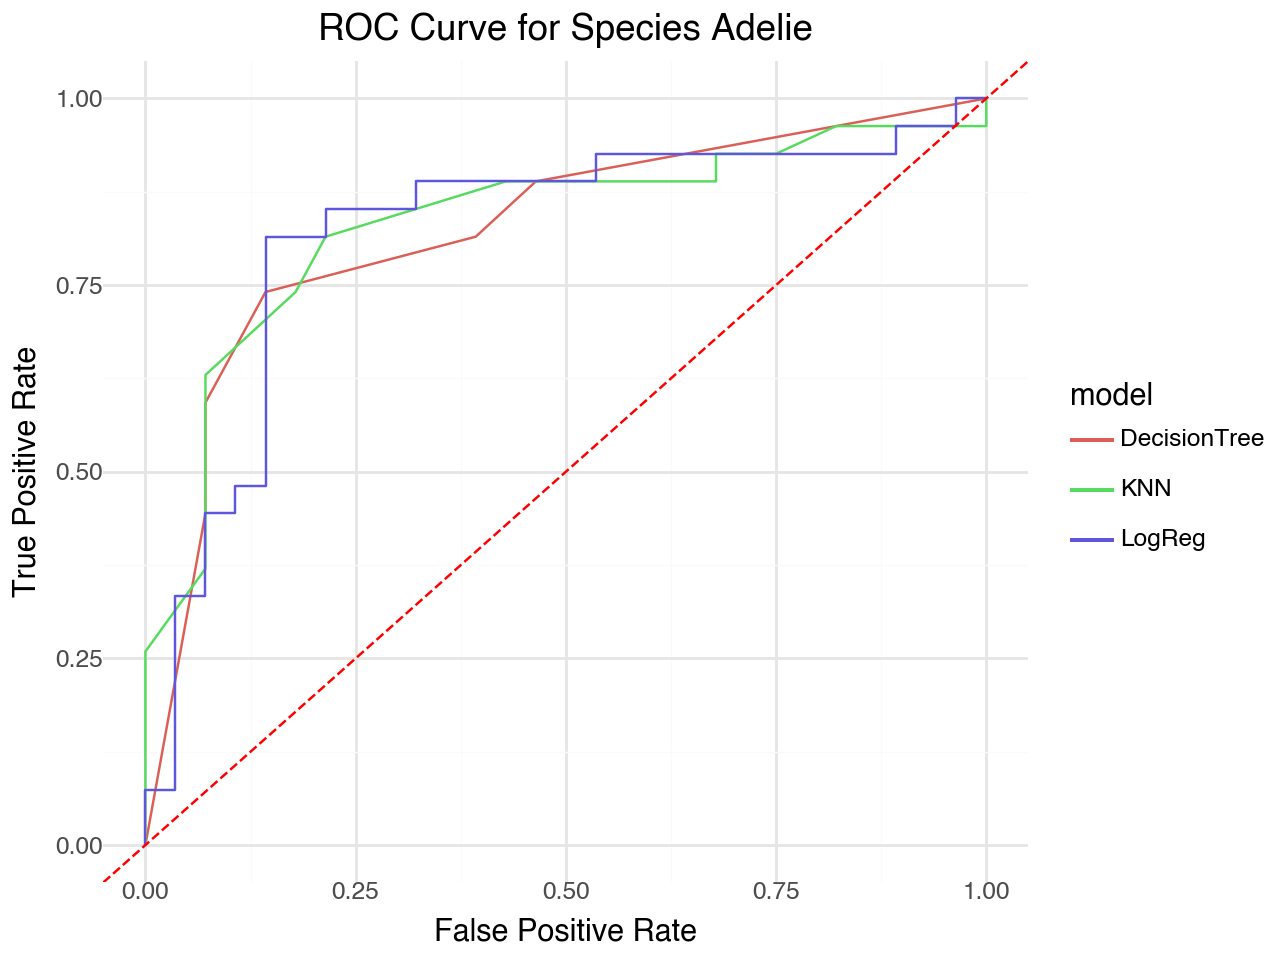

In [276]:
# KNN
fpr_knn, tpr_knn, _ = roc_curve(y_test, best_knn[1])

# Logistic Regression
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, best_lr[1])

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, best_dt[1])


roc_data = pd.DataFrame({
    'FPR': np.concatenate([fpr_knn, fpr_logreg, fpr_dt]),
    'TPR': np.concatenate([tpr_knn, tpr_logreg, tpr_dt]),
    'model': ['KNN'] * len(fpr_knn) + ['LogReg'] * len(fpr_logreg) + ['DecisionTree'] * len(fpr_dt)
})

# Create the ROC plot using plotnine

roc_plot = (
    ggplot(roc_data, aes(x='FPR', y='TPR', color = 'model')) +
    geom_line() +
    geom_abline(intercept=0, slope=1, linetype="dashed", color="red") +
    labs(
        x="False Positive Rate",
        y="True Positive Rate",
        title=f"ROC Curve for Species Adelie"
    ) +
    theme_minimal()
)
display(roc_plot)

# Part Two: Metrics

Consider the following metrics:

- True Positive Rate or Recall or Sensitivity = Of the observations that are truly Class A, how many were predicted to be Class A?

- Precision or Positive Predictive Value = Of all the observations classified as Class A, how many of them were truly from Class A?

- True Negative Rate or Specificity or Negative Predictive Value = Of all the observations classified as NOT Class A, how many were truly NOT Class A?

Compute each of these metrics (cross-validated) for your three models (KNN, Logistic Regression, and Decision Tree) in Part One.

In [ ]:
# Metrics for all models
metrics = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Decision Tree'],
    'AUC': [best_knn[2], best_lr[2], best_dt[2]],
    'Precision': [best_knn[3], best_lr[3], best_dt[3]],
    'Recall': [best_knn[4], best_lr[4], best_dt[4]],
    'Specificity': [best_knn[7], best_lr[7], best_dt[7]]
})
metrics

,Model,AUC,Precision,Recall,Specificity
0,KNN,0.833995,0.718750,0.851852,0.678571
1,Logistic Regression,0.822751,0.741935,0.851852,0.714286
2,Decision Tree,0.824735,0.833333,0.740741,0.857143


# Part Three: Discussion

Suppose you have been hired by a hospital to create classification models for heart attack risk.<br>

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:<br>

- Which metric(s) you would use for model selection and why.<br>

- Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.<br>

- What score you should expect for your chosen metric(s) using your chosen model to predict future observations.<br>

### Q1
The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack. <br>

- Recall metric should be used. As it reduces the chances of missing patients who are at risk (false negatives).<br>
- Both KNN and Logistic Regressionn have same Recall value, but logistic regression have better specificity so I will choose Logistic regression.<br>
- Recall score for logistic regression whould 85.2% which means it will be correct 85% of the times.<br>

### Q2
The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.<br>
- Precisionn should be used. At the accuracy of classifing true patients at risk will be more.<br>
- Decisionn Tree will be recommanded as it has the highest precision and specificity.<br>
- Precision score of Decision Tree will be 83.3% which mean it will 83% of the time correctly classify the at risk patients.<br>

### Q3
The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.<br>
- AUC should be used as it will give the overall performance.<br>
- KNN shuold be used as it the the highest AUC score.<br>
- Expected score for the AUC of KNN will be 83.3%.<br>

### Q4
The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.<br>
- Cohan's Kappa should be used as it works best for compairing the two probable outcome.<br>
- For the model we should used KNN as it has the highest AUC score as it gives us the overall performance of the model.<br>
- Expected score of the model will 83.3% but the cohan's kappa score will vary depending on the doctor's predictions.<br>

# Part Four: Validation

Before sharing the dataset with you, I set aside a random 10% of the observations to serve as a final validation set.

In [278]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

In [279]:
ha_validation.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,41,0,1,130,204,0,172,1
1,64,1,3,110,211,0,144,1
2,59,1,0,135,234,1,161,1
3,42,1,0,140,226,1,178,1
4,40,1,3,140,199,1,178,1


In [280]:
ha_validation.isnull().sum()

age        0
sex        0
cp         0
trtbps     0
chol       0
restecg    0
thalach    0
output     0
dtype: int64

In [281]:
X_val = ha_validation.drop('output',axis=1)
y_val = ha_validation['output']

Use each of your final models in Part One Q1-3, predict the target variable in the validation dataset.<br>
For each, output a confusion matrix, and report the ROC AUC, the precision, and the recall.

In [282]:
knn_val = modelPipeline(KNeighborsClassifier(n_neighbors = 20), X_test= X_val, y_test= y_val)

AUC Score: 0.9688995215311005
Confusion Matrix:
[[10  1]
 [ 3 16]]


In [283]:
lr_val = modelPipeline(LogisticRegression(C = 1, penalty = 'l2', solver = 'liblinear'), X_test= X_val, y_test= y_val)

AUC Score: 0.9186602870813397
Confusion Matrix:
[[10  1]
 [ 4 15]]


In [284]:
dt_val = modelPipeline(DecisionTreeClassifier(criterion='gini', max_depth = 3, min_samples_leaf = 2, min_samples_split = 2), X_test= X_val, y_test= y_val)

AUC Score: 0.8803827751196173
Confusion Matrix:
[[11  0]
 [ 8 11]]


In [292]:
val_metrics = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Decision Tree'],
    'AUC': [knn_val[2], lr_val[2], dt_val[2]],
    'Precision': [knn_val[3], lr_val[3], dt_val[3]],
    'Recall': [knn_val[4], lr_val[4], dt_val[4]],
})

val_metrics

,Model,AUC,Precision,Recall
0,KNN,0.968900,0.941176,0.842105
1,Logistic Regression,0.918660,0.937500,0.789474
2,Decision Tree,0.880383,1.000000,0.578947


Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?<br>

Our model predictions were successful for the validation dataset, providing reliable metrics.

# Part Five: Cohen’s Kappa

In [286]:
val_metrics = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Decision Tree'],
    "Cohen's Kappa score": [best_knn[5], best_lr[5], best_dt[5]]
})
val_metrics

,Model,Cohen's Kappa score
0,KNN,0.528675
1,Logistic Regression,0.564644
2,Decision Tree,0.599072


Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. Do your conclusions from above change if you judge your models using Cohen’s Kappa instead? Does this make sense?

Cohan's Kappa scores doesn't make sense here. As we are comapiring two raters in which one is our dataset (assuming it is 100% correct). The marginal probabilitess doesn't make sense as the given data will be correct everytime while comparing to the model's prediction.<br>
But it would make sense we are comaparing two models or models Vs doctors.